In [80]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
count=0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
        if count == 5:
            break
    if count == 5:  # ensure we stop outer loop too
        break
            
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight/1e5ba644-efeb-4bd3-b878-a0606cf8a992___RS_Late.B 6272_flipLR.JPG
/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight/3dcee9ed-43bb-45a9-8cff-641b3dd62179___RS_Late.B 5324.JPG
/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight/532b2c20-d17b-4b3e-a69e-54a6e5343014___GHLB2 Leaf 9004.JPG
/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight/418ae33c-5f61-4531-82df-8608d82a7a90___RS_Late.B 5574.JPG
/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight/7f4621fe-72ce-4f4c-a20e-320250ec8a9d___R

In [81]:
import tensorflow as tf
from tensorflow.keras import layers, models
import math

In [82]:
TRAIN_DIR = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
VAL_DIR = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
IMAGE_SIZE=(224,224)
BATCH_SIZE=32

# Normalize images
def preprocess(img, label):
    img = tf.cast(img, tf.float32) / 255.0
    return img, label
    
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True
).map(preprocess).repeat().prefetch(tf.data.AUTOTUNE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)
class_names=val_ds.class_names
val_ds=val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [83]:
def se_block(inputs, se_ratio=0.25):
    filters = inputs.shape[-1]
    se_filters = max(1, int(filters * se_ratio))
    se = layers.GlobalAveragePooling2D()(inputs)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Conv2D(se_filters, 1, activation='relu')(se)
    se = layers.Conv2D(filters, 1, activation='sigmoid')(se)
    return layers.Multiply()([inputs, se])


In [84]:
def cbam_block(inputs, reduction_ratio=16):
    # Channel Attention
    channel_avg = layers.GlobalAveragePooling2D()(inputs)
    channel_max = layers.GlobalMaxPooling2D()(inputs)
    
    shared_dense = tf.keras.Sequential([
        layers.Dense(inputs.shape[-1] // reduction_ratio, activation='relu'),
        layers.Dense(inputs.shape[-1])
    ])

    avg_out = shared_dense(channel_avg)
    max_out = shared_dense(channel_max)

    channel_attention = layers.Add()([avg_out, max_out])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, 1, inputs.shape[-1]))(channel_attention)
    x = layers.Multiply()([inputs, channel_attention])

    # Spatial Attention using only Keras layers
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    x = layers.Multiply()([x, spatial_attention])

    return x

In [85]:
def mbconv_block(inputs, out_channels, expansion_factor, kernel_size, strides, se_ratio=0.25):
    in_channels = inputs.shape[-1]
    x = inputs

    # Expansion phase
    if expansion_factor != 1:
        x = layers.Conv2D(in_channels * expansion_factor, 1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('swish')(x)

    # Depthwise conv
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # Squeeze-and-Excitation
    x = se_block(x, se_ratio=se_ratio)

    # Projection phase
    x = layers.Conv2D(out_channels, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Skip connection
    if strides == 1 and in_channels == out_channels:
        x = layers.Add()([inputs, x])
    
    return x

In [86]:
def EfficientNetB0_custom(input_shape=(224,224, 3), num_classes=38, dropout_rate=0.2):
    inputs = tf.keras.Input(shape=input_shape)

    # Stem
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # MBConv blocks (adapted from official B4 config)
    # (repeats, out_channels, kernel_size, strides)
    x = mbconv_block(x,out_channels=16,expansion_factor=1,kernel_size=3,strides=1)
    block_configs = [
        (2, 24, 3, 2),
        (2, 40, 5, 2),
        (3, 80, 3, 2),
        (3, 112, 5, 1),
        (4, 192, 5, 2),
        (1, 320, 3, 1),
    ]

    expansion_factor = 6
    for repeats, out_channels, kernel_size, strides in block_configs:
        for i in range(repeats):
            x = mbconv_block(
                x,
                out_channels=out_channels,
                expansion_factor=expansion_factor,
                kernel_size=kernel_size,
                strides=strides if i == 0 else 1
            )

    # Head
    x = layers.Conv2D(1280, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # Convolutional Block Attention Module
    x = cbam_block(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [87]:
model_e_cbam = EfficientNetB0_custom()

In [88]:
from tensorflow.keras.models import load_model
model_e_cbam.load_weights('/kaggle/input/efficient_net_b0_cbam/tensorflow2/default/1/efficientnet_b0_new_model.h5')

In [89]:
#classification report
import numpy as np
from sklearn.metrics import classification_report
true_labels = []
for _, labels in val_ds.unbatch():
    true_labels.append(tf.argmax(labels).numpy())
true_labels = np.array(true_labels)

# 2. Get predicted labels
pred_labels = []
for images, _ in val_ds:
    preds = model_e_cbam.predict(images,verbose=0)
    pred_classes = np.argmax(preds, axis=1)
    pred_labels.extend(pred_classes)
pred_labels = np.array(pred_labels)

report = classification_report(true_labels, pred_labels, target_names=class_names)
print(report)
# Save to a text file
with open("classification_report.txt", "w") as f:
    f.write(report)

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      1.00      0.99       504
                                 Apple___Black_rot       1.00      1.00      1.00       497
                          Apple___Cedar_apple_rust       0.99      0.98      0.99       440
                                   Apple___healthy       0.97      1.00      0.98       502
                               Blueberry___healthy       1.00      0.98      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      0.99       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.96      0.97       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
               Corn_(maize)___Northern_Leaf_Blight       0.97      0.97      0.

In [90]:
for i, layer in enumerate(model_e_cbam.layers):
    output_shape = getattr(layer, 'output_shape', 'N/A')
    print(f"{i:02d}. {layer.name:30s} --> Output shape: {output_shape}")

00. input_layer_21                 --> Output shape: N/A
01. conv2d_213                     --> Output shape: N/A
02. batch_normalization_147        --> Output shape: N/A
03. activation_117                 --> Output shape: N/A
04. depthwise_conv2d_48            --> Output shape: N/A
05. batch_normalization_148        --> Output shape: N/A
06. activation_118                 --> Output shape: N/A
07. global_average_pooling2d_69    --> Output shape: N/A
08. reshape_66                     --> Output shape: N/A
09. conv2d_214                     --> Output shape: N/A
10. conv2d_215                     --> Output shape: N/A
11. multiply_84                    --> Output shape: N/A
12. conv2d_216                     --> Output shape: N/A
13. batch_normalization_149        --> Output shape: N/A
14. conv2d_217                     --> Output shape: N/A
15. batch_normalization_150        --> Output shape: N/A
16. activation_119                 --> Output shape: N/A
17. depthwise_conv2d_49        

In [91]:
# Image paths (replace with your list of 30 images)
image_names=['AppleCedarRust1','AppleCedarRust2','AppleCedarRust3','AppleCedarRust4','AppleScab1','AppleScab2','AppleScab3',
             'CornCommonRust1','CornCommonRust2','CornCommonRust3','PotatoEarlyBlight1','PotatoEarlyBlight2','PotatoEarlyBlight3',
             'PotatoEarlyBlight4','PotatoEarlyBlight5','PotatoHealthy1','PotatoHealthy2','TomatoEarlyBlight1','TomatoEarlyBlight2',
             'TomatoEarlyBlight3','TomatoEarlyBlight4','TomatoEarlyBlight5','TomatoEarlyBlight6','TomatoHealthy1','TomatoHealthy2',
             'TomatoHealthy3','TomatoHealthy4','TomatoYellowCurlVirus1','TomatoYellowCurlVirus2','TomatoYellowCurlVirus3','TomatoYellowCurlVirus4',
             'TomatoYellowCurlVirus5','TomatoYellowCurlVirus6']
image_paths = [f"/kaggle/input/new-plant-diseases-dataset/test/test/{img}.JPG" for img in image_names]

In [132]:
def get_nth_last_conv_layer_name(model, n=1):
    conv_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
    if len(conv_layers) < n:
        raise ValueError(f"Model has only {len(conv_layers)} Conv2D layers, can't get {n}-th last.")
    return conv_layers[-n].name

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1032']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


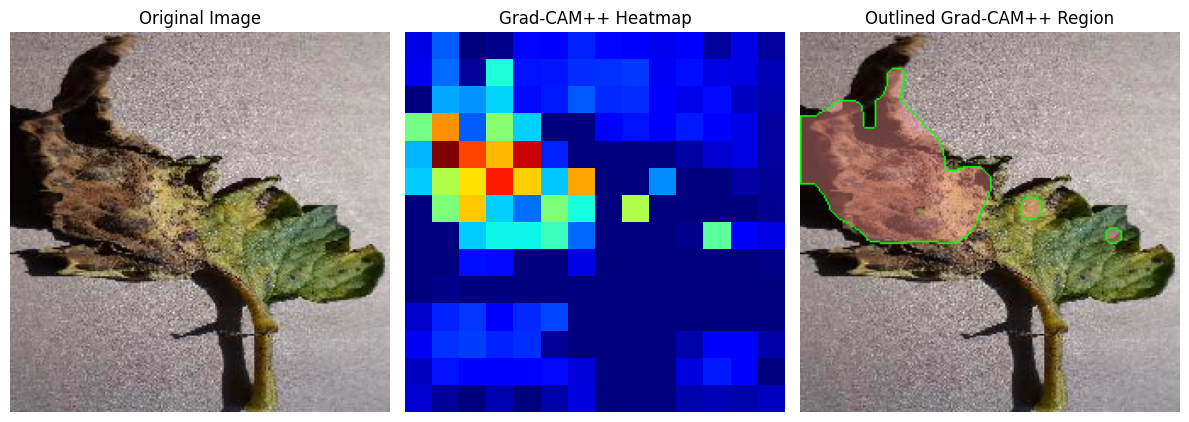

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1032']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


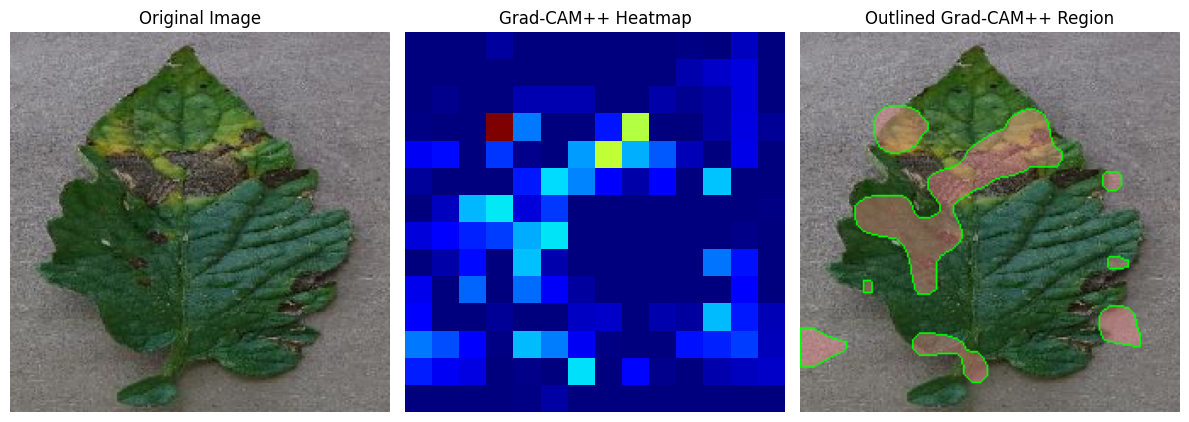

EfficientNet CBAM Grad-CAM++ completed for all images.


In [136]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Grad-CAM++ Function
def gradCAM_plus_plus(img, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                conv_outputs, predictions = grad_model(img)
                pred_index = tf.argmax(predictions[0])
                class_channel = predictions[:, pred_index]

            grads = tape3.gradient(class_channel, conv_outputs)
        first_derivative = grads
        second_derivative = tape2.gradient(grads, conv_outputs)
    third_derivative = tape1.gradient(second_derivative, conv_outputs)

    conv_outputs = conv_outputs[0]
    first_derivative = first_derivative[0]
    second_derivative = second_derivative[0]
    third_derivative = third_derivative[0]

    global_sum = np.sum(conv_outputs.numpy(), axis=(0, 1))
    alpha_num = second_derivative.numpy()
    alpha_denom = 2 * second_derivative.numpy() + third_derivative.numpy() * global_sum[np.newaxis, np.newaxis, :]
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

    alphas = alpha_num / alpha_denom
    weights = np.maximum(first_derivative.numpy(), 0.0)
    deep_linearization_weights = np.sum(alphas * weights, axis=(0, 1))

    heatmap = np.sum(deep_linearization_weights * conv_outputs.numpy(), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8

    return heatmap

# Outline with Adaptive Threshold
def draw_gradcam_fill_and_outline(heatmap, original_img, threshold_ratio=0.5, 
                                   fill_color=(255, 150, 150), outline_color=(0, 255, 0),
                                   fill_alpha=0.4, outline_thickness=1):
    if original_img.max() <= 1.0:
        img_uint8 = (original_img * 255).astype(np.uint8)
    else:
        img_uint8 = original_img.copy()

    heatmap_resized = cv2.resize(heatmap, (img_uint8.shape[1], img_uint8.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    threshold = int(threshold_ratio * 255)
    _, binary_mask = cv2.threshold(heatmap_resized, threshold, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)

    overlay = np.full_like(img_uint8, fill_color, dtype=np.uint8)
    mask_3ch = np.stack([cleaned_mask]*3, axis=-1) // 255
    filled_img = np.where(mask_3ch, cv2.addWeighted(img_uint8, 1 - fill_alpha, overlay, fill_alpha, 0), img_uint8)

    contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    outlined = cv2.drawContours(filled_img.copy(), contours, -1, outline_color, outline_thickness)

    return (outlined / 255.0) if original_img.max() <= 1.0 else outlined

# Grad-CAM++ for multiple images
last_conv_layer_name = get_nth_last_conv_layer_name(model_e_cbam,n=43)  # Update as needed
output_dir = "./gradcam_outputs"
os.makedirs(output_dir, exist_ok=True)

for i, img_path in enumerate(image_paths):
    if i==17 or i==20:
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        heatmap = gradCAM_plus_plus(img_array, model_e_cbam, last_conv_layer_name)

        # Adaptive threshold: Keep top 15% activations
        percentile = 85
        threshold_value = np.percentile(heatmap, percentile)
        threshold_ratio = threshold_value / (np.max(heatmap) + 1e-8)

        outlined_img = draw_gradcam_fill_and_outline(heatmap, img_array[0], threshold_ratio=threshold_ratio)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(img_array[0])
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Grad-CAM++ Heatmap")
        plt.imshow(heatmap, cmap='jet')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Outlined Grad-CAM++ Region")
        plt.imshow(outlined_img)
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(f'gradcam_output {i+1}.jpg')
        plt.show()
    

print("EfficientNet CBAM Grad-CAM++ completed for all images.")